In [1]:
from scipy.stats import pearsonr
import geopandas as gpd
import libpysal
import matplotlib
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

os.chdir("../")

from epitools import get_data

#### Income inequality

In [40]:
df_gini = pd.read_csv("Income_Inequality.csv")
df_gini.head()

,state,gini,moe,year
0,ALABAMA,0.470,±0.003,2008
1,ALASKA,0.412,±0.006,2008
2,ARIZONA,0.453,±0.002,2008
3,ARKANSAS,0.459,±0.003,2008
4,CALIFORNIA,0.469,±0.001,2008


In [5]:
output = []
method = "nv"

for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    df_tmp = get_data(
        country="United States",
        aggregation="state",
        election="first_round",
        year=year
    )
    output.append(df_tmp)

df_dv = pd.concat(output, ignore_index=True)
df_dv = df_dv.rename(columns={"epi": "value"})
df_dv["state"] = df_dv["state"].str.upper()

df_dv.head()

,state,ec,ep,year
0,ALABAMA,0.812398,0.142140,2000
1,ALASKA,0.648163,0.143164,2000
2,ARIZONA,0.886976,0.082218,2000
3,ARKANSAS,0.842943,0.149267,2000
4,CALIFORNIA,0.782541,0.214961,2000


In [6]:
# https://data.census.gov/cedsci/table?q=urban%20areas%20by%20state&tid=DECENNIALCD1132010.H2&tp=true
df_rurality = pd.read_csv("data_external/United States/DECENNIALCD1132010.H2-2022-11-02T160811.csv").dropna()
df_rurality = df_rurality.rename(columns={
    "Label (Grouping)": "state",
    "Total:!!Urban:": "urban",
    "Total:!!Rural": "rural"
})
df_rurality["state"] = df_rurality["state"].str.upper().str.replace(u"\xa0", "")
for col in ["urban", "rural"]:
    df_rurality[col] = df_rurality[col].str.replace(u"\u202f", "").astype(int)
df_rurality["rurality"] = df_rurality["rural"] / (df_rurality["urban"] + df_rurality["rural"])
# df_rurality = df_rurality[["state", "rurality"]]
df_rurality.head()

,state,Total:,urban,Total:!!Urban:!!Inside urbanized areas,Total:!!Urban:!!Inside urban clusters,rural,Total:!!Not defined for this file,rurality
1,ALABAMA,2 171 853 (r15032),1267224,1 040 659,226 565,904629,0.0,0.416524
3,ALASKA,306 967 (r15611),182989,123 286,59 703,123978,0.0,0.403881
5,ARIZONA,2 844 526,2515504,2 242 637,272 867,329022,0.0,0.115668
7,ARKANSAS,1 316 299 (r15934),720584,506 573,214 011,595715,0.0,0.452568
9,CALIFORNIA,13 680 081,12814688,12 051 891,762 797,865393,0.0,0.063259


In [7]:
df_political = pd.read_csv("data_output/United States/Political_Polarization_ANES.csv")
df_political.head()

,political,year,fips,N,state
0,5.777291,2012,1,13,ALABAMA
1,6.999124,2020,1,19,ALABAMA
2,3.918351,1996,4,10,ARIZONA
3,4.950007,2008,4,12,ARIZONA
4,4.614009,2012,4,17,ARIZONA


In [8]:
df_income1 = pd.read_csv(
    "https://www2.census.gov/programs-surveys/decennial/tables/time-series/historical-income-states/state1.csv",
    header=2
)
df_income1.columns = ["state", "1999", "1989_c", "1989", "1979_c", "1979", "1969_c", "1969"]
df_income1 = df_income1[2:].dropna()

for col in list(df_income1):
    df_income1[col] = df_income1[col].str.replace(",", "")

df_income1.head()

,state,1999,1989_c,1989,1979_c,1979,1969_c,1969
2,Alabama,34135,23597,30786,13669,29243,6419,25151
3,Alaska,51571,41408,54023,25414,54369,11817,46301
4,Arizona,40558,27540,35930,16448,35188,8199,32125
5,Arkansas,32182,21147,27589,12214,26130,5356,20986
6,California,47493,35798,46704,18243,39028,9302,36447


In [9]:
def clean_bea_data(
    PATH,
    value_name="value"
):
    tmp = pd.read_csv(PATH, header=3).dropna(subset=["GeoName"])
    tmp = tmp.melt(id_vars=["GeoFips", "GeoName"], var_name="year", value_name=value_name)
    tmp = tmp.rename(columns={"GeoFips": "state_id", "GeoName": "state"})
    tmp = tmp[~(tmp["state_id"].str[0] == "9")]
    tmp = tmp[tmp[value_name] != "(NA)"]
    tmp = tmp[tmp["state_id"] != "00000"]
    tmp["state"] = tmp["state"].replace({" *": ""}).str.upper()
    tmp = tmp.drop(columns=["state_id"])
    tmp[value_name] = tmp[value_name].astype(float)
    tmp["year"] = tmp["year"].astype(int)

    return tmp


In [10]:
def clean_shadac_data(
    PATH,
    value_name="value"
):
    tmp = pd.read_csv(PATH, header=4)
    tmp = tmp.rename(columns={"Location": "state", "TimeFrame": "year", "Data": value_name})
    tmp = tmp[["state", "year", value_name]]
    tmp = tmp[tmp["state"] != "United States"]
    tmp[value_name] = tmp[value_name].astype(float)
    tmp["state"] = tmp["state"].str.upper()

    return tmp

In [11]:
df_unemployment = clean_shadac_data(
    PATH = "data_external/United States/SHADAC_Unemployment.csv",
    value_name = "unemployment"
)
df_unemployment["state"] = df_unemployment["state"].replace({"DIST. OF COLUMBIA": "DISTRICT OF COLUMBIA"})
df_unemployment.head()

,state,year,unemployment
0,ALABAMA,2000,0.041
1,ALABAMA,2001,0.047
2,ALABAMA,2002,0.054
3,ALABAMA,2003,0.054
4,ALABAMA,2004,0.050


In [12]:
df_expenditure = clean_bea_data(
    PATH = "data_external/United States/BEA_Personal_Expenditure.csv",
    value_name = "expenditure"
)
df_expenditure.head()

,state,year,expenditure
1,ALABAMA,1997,17645.0
2,ALASKA,1997,23175.0
3,ARIZONA,1997,20343.0
4,ARKANSAS,1997,16124.0
5,CALIFORNIA,1997,20829.0


In [13]:
# df_gini = clean_shadac_data(
#     PATH = "data_external/United States/SHADAC_Inequality.csv",
#     value_name = "gini"
# )
# df_gini.head()

In [14]:
df_personal_income = clean_bea_data(
    PATH="data_external/United States/BEA_Personal_income.csv",
    value_name="personal_income"
)

df_personal_income["state"] = df_personal_income["state"].replace({"HAWAII *": "HAWAII", "ALASKA *": "ALASKA"})
df_personal_income.head()

,state,year,personal_income
1,ALABAMA,1929,319.0
3,ARIZONA,1929,598.0
4,ARKANSAS,1929,303.0
5,CALIFORNIA,1929,994.0
6,COLORADO,1929,631.0


In [15]:
df_population = clean_bea_data(
    PATH="data_external/United States/BEA_Population.csv",
    value_name="population"
)
df_population.head()

,state,year,population
1,ALABAMA,1929,2644000.0
3,ARIZONA,1929,430000.0
4,ARKANSAS,1929,1852000.0
5,CALIFORNIA,1929,5531000.0
6,COLORADO,1929,1008000.0


In [26]:
df_population_00_10 = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/state/st-est00int-alldata.csv")
df_population_00_10 = df_population_00_10.query("SEX == 0 & ORIGIN == 0 & RACE == 0 & AGEGRP == 0")
cols = [f"POPESTIMATE{x}" for x in range(2000, 2010 + 1)]
aggs = {}
for col in cols:
    aggs[col] = "sum"

df_population_00_10 = df_population_00_10.groupby("NAME").agg(aggs).reset_index().melt(id_vars=["NAME"], var_name="year", value_name="population")
df_population_00_10["year"] = df_population_00_10["year"].str.replace("POPESTIMATE", "").astype(int)
df_population_00_10 = df_population_00_10.rename(columns={"NAME": "state"})
df_population_00_10["state"] = df_population_00_10["state"].str.upper()
df_population_00_10.head()

,state,year,population
0,ALABAMA,2000,4452173
1,ALASKA,2000,627963
2,ARIZONA,2000,5160586
3,ARKANSAS,2000,2678588
4,CALIFORNIA,2000,33987977


In [28]:
def get_population_data(PATH, initial_year=2000, end_year=2010):
    input_df = pd.read_csv(PATH)
    cols = [f"POPESTIMATE{x}" for x in range(initial_year, end_year + 1)]
    aggs = {}
    for col in cols:
        aggs[col] = "sum"

    if initial_year == 2000:
        input_df = input_df[(input_df["SEX"] == 0) & (input_df["ORIGIN"] == 0)
                            & (input_df["RACE"] == 0)  & (input_df["AGEGRP"] == 0)] # SEX	ORIGIN	RACE	AGEGRP

    input_df = input_df[["NAME"] + cols]
    # display(input_df[input_df["NAME"] == "Alaska"].POPESTIMATE2000.sum())

    input_df = input_df.melt(id_vars=["NAME"], var_name="year", value_name="population")
    input_df["year"] = input_df["year"].str.replace("POPESTIMATE", "").astype(int)
    input_df = input_df.rename(columns={"NAME": "state"})
    input_df["state"] = input_df["state"].str.upper()
    input_df = input_df[input_df["state"] != "UNITED STATES"].groupby(["state", "year"]).agg({"population": "sum"}).reset_index()
    
    return input_df

In [29]:
df_population_00_10 = get_population_data(
    "https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/state/st-est00int-alldata.csv",
    initial_year=2000,
    end_year=2010
)

df_population_00_10[df_population_00_10["state"] == "ALASKA"]#.groupby("NAME").agg({"POPESTIMATE2000": "sum"})

,state,year,population
11,ALASKA,2000,627963
12,ALASKA,2001,633714
13,ALASKA,2002,642337
14,ALASKA,2003,648414
15,ALASKA,2004,659286
16,ALASKA,2005,666946
17,ALASKA,2006,675302
18,ALASKA,2007,680300
19,ALASKA,2008,687455
20,ALASKA,2009,698895


In [30]:
df_population_00_10 = get_population_data(
    "https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/state/st-est00int-alldata.csv",
    initial_year=2000,
    end_year=2010
)

df_population_10_20 = get_population_data(
    "https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/nst-est2020-alldata.csv",
    initial_year=2010,
    end_year=2020
)
df_population_10_20 = df_population_10_20[df_population_10_20["year"] > 2010]

df_population = pd.concat([df_population_00_10, df_population_10_20])
df_population.head()

,state,year,population
0,ALABAMA,2000,4452173
1,ALABAMA,2001,4467634
2,ALABAMA,2002,4480089
3,ALABAMA,2003,4503491
4,ALABAMA,2004,4530729


In [31]:
df_area = pd.read_html("https://www.census.gov/geographies/reference-files/2010/geo/state-area.html")[0]
df_area = df_area[[
    ("State and other areas2", "State and other areas2", "State and other areas2"),
    ("Land Area1", "Land Area1", "Sq. Km.")]
].dropna()[2:]
df_area.columns = ["state", "sq_km"]
df_area["state"] = df_area["state"].str.replace(":5", "").str.upper()
df_area = df_area.reset_index(drop=True)
df_area.head()

,state,sq_km
0,ALABAMA,131171.0
1,ALASKA,1477953.0
2,ARIZONA,294207.0
3,ARKANSAS,134771.0
4,CALIFORNIA,403466.0


In [32]:
df_population = pd.merge(df_population, df_area, on="state")
df_population["pop_density"] = df_population["population"] / df_population["sq_km"]

In [33]:
df_gdp = clean_bea_data(
    PATH="data_external/United States/BEA_Real_GDP.csv",
    value_name="gdp"
)
df_gdp.head()

,state,year,gdp
1,ALABAMA,1998,149568.2
2,ALASKA,1998,41095.9
3,ARIZONA,1998,183060.5
4,ARKANSAS,1998,84570.8
5,CALIFORNIA,1998,1468730.8


In [34]:
df_attainment_00 = pd.read_excel(
    "https://www2.census.gov/library/publications/2011/compendia/statab/131ed/tables/12s0233.xls",
    header=3
)

df_attainment_00 = df_attainment_00[["State", "Unnamed: 8"]]
df_attainment_00 = df_attainment_00.rename(columns={"State": "state", "Unnamed: 8": "ed_attainment"})
df_attainment_00["year"] = 2000
df_attainment_00 = df_attainment_00.dropna()
df_attainment_00.head()


df_attainment_04 = pd.read_excel(
    "https://www2.census.gov/programs-surveys/demo/tables/educational-attainment/2004/cps-detailed-tables/tab13.xls",
    header=4
).dropna()

df_attainment_04 = df_attainment_04.rename(columns={"State": "state", "Bachelor's degree or higher\nPercent": "ed_attainment"})
df_attainment_04 = df_attainment_04[["state", "ed_attainment"]]
df_attainment_04["year"] = 2004
df_attainment_04.head()

output = []

for year in range(2006, 2021 + 1):
    tmp = pd.read_html(f"https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od={year}-01-01#")[0]
    tmp = tmp[[("Unnamed: 1_level_0", "Name"), ("Percent", str(year))]]
    tmp.columns = ["state", "ed_attainment"]
    tmp["state"] = tmp["state"].str.upper()
    tmp["year"] = year

    output.append(tmp)

df_attainment = pd.concat([df_attainment_00, df_attainment_04] + output, ignore_index=True)
df_attainment["state"] = df_attainment["state"].str.upper()
df_attainment["ed_attainment"] = df_attainment["ed_attainment"] / 100
df_attainment.head()

,state,ed_attainment,year
0,UNITED STATES,0.244016,2000
1,ALABAMA,0.190347,2000
2,ALASKA,0.247149,2000
3,ARIZONA,0.23531,2000
4,ARKANSAS,0.166606,2000


In [35]:
set(df_attainment.state.unique()) - set(df_dv.state.unique())

{'    UNITED STATES'}

In [36]:
print(set(df_population.state.unique()) - set(df_dv.state.unique()))
print(set(df_dv.state.unique()) - set(df_population.state.unique()))

{'PUERTO RICO'}
set()


In [37]:
df_population[df_population["state"] == "HAWAII"]

,state,year,population,sq_km,pop_density
231,HAWAII,2000,1213519,16635.0,72.949745
232,HAWAII,2001,1225948,16635.0,73.696904
233,HAWAII,2002,1239613,16635.0,74.518365
234,HAWAII,2003,1251154,16635.0,75.212143
235,HAWAII,2004,1273569,16635.0,76.559603
236,HAWAII,2005,1292729,16635.0,77.711392
237,HAWAII,2006,1309731,16635.0,78.733454
238,HAWAII,2007,1315675,16635.0,79.090772
239,HAWAII,2008,1332213,16635.0,80.084941
240,HAWAII,2009,1346717,16635.0,80.956838


In [38]:
cols = {
    "2000": "Unnamed: 2",
    "2004": "Unnamed: 2",
    "2008": "Unnamed: 2",
    "2012": "Unnamed: 2",
    "2016": "Unnamed: 4",
    "2020": "Unnamed: 5"
}

output = []
for year in range(2000, 2021, 4):
    df_turnout = pd.read_csv(f"data_external/United States/Turnout/{year} November General Election - Turnout Rates.csv")
    df_turnout = df_turnout[["State", cols[str(year)]]].dropna()
    df_turnout.columns = ["state", "turnout"]
    df_turnout["year"] = year
    df_turnout["turnout"] = df_turnout["turnout"].str.replace("%", "").astype(float) / 100
    output.append(df_turnout)

df_turnout = pd.concat(output, ignore_index=True)
df_turnout["state"] = df_turnout["state"].str.upper()
df_turnout.head()

,state,turnout,year
0,UNITED STATES,0.542,2000
1,ALABAMA,0.516,2000
2,ALASKA,0.681,2000
3,ARIZONA,0.456,2000
4,ARKANSAS,0.479,2000


In [44]:
data = pd.merge(
    df_gini,
    df_dv,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_attainment,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_gdp,
    on=["state", "year"],
    how="outer"
)

# data = pd.merge(
#     data,
#     pd.read_csv("data_output/United States/Polarization_ANES.csv"),
#     on=["state", "year"],
#     how="outer"
# )

# data = pd.merge(
#     data,
#     pd.read_csv("data_output/United States/Affective_Polarization_ANES.csv"),
#     on=["state", "year"],
#     how="outer"
# )

data = pd.merge(
    data,
    pd.read_csv("data_output/United States/Polarization_CCNES.csv"),
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    pd.read_csv("data_output/United States/Political_Polarization_ANES.csv"),
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_expenditure,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_personal_income,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_unemployment,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_population,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_turnout,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    pd.read_csv("States_Type_United_States.csv"),
    on="state"
)

data = data.rename(columns={"polarization2": "polarization"})

values = ["ep", "ec", "gini", "population", "expenditure", "ed_attainment", "polarization"]
data[values] = data[values].astype(float)
# data["affective"] = data["affective"] / 100
data = data.sort_values("year")
data = data[data["year"] > 1996]
data.head()

,state,gini,moe,year,ec,ep,ed_attainment,gdp,polarization,N_x,...,fips,N_y,expenditure,personal_income,unemployment,population,sq_km,pop_density,turnout,type
2679,NEW HAMPSHIRE,NaN,NaN,1997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23201.0,27975.0,NaN,NaN,NaN,NaN,NaN,PARTISAN
3144,NORTH DAKOTA,NaN,NaN,1997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,18473.0,21196.0,NaN,NaN,NaN,NaN,NaN,PARTISAN
2865,NEW MEXICO,NaN,NaN,1997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17320.0,20576.0,NaN,NaN,NaN,NaN,NaN,PARTISAN
2122,MINNESOTA,NaN,NaN,1997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22682.0,27087.0,NaN,NaN,NaN,NaN,NaN,PARTISAN
840,FLORIDA,NaN,NaN,1997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22097.0,25378.0,NaN,NaN,NaN,NaN,NaN,SWING


In [46]:
# "affective", "political", 

for measure in ["expenditure", "gini", "ep", "ec", "personal_income", "population", "gdp", "unemployment", "ed_attainment", "pop_density"]:
    data[f"{measure}_1"] = data.dropna(subset=["ep"]).groupby("state")[measure].shift(periods=1)
    data[f"{measure}_g"] = (data[measure] - data[f"{measure}_1"])
    data[f"{measure}_r"] = (data[measure] - data[f"{measure}_1"]) / data[f"{measure}_1"]

pd.set_option('use_inf_as_na', True)
data.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)

In [ ]:
# gdf = gpd.read_file(f"geo_shapes/composite_us_states.geojson")
# gdf = gdf.rename(columns={"name": "state"})
# gdf["state"] = gdf["state"].str.upper()

In [ ]:
# warnings.filterwarnings("ignore")
# data1 = pd.merge(gdf[["state", "geometry"]], data, on="state")
# print(data1.shape)

# output = []
# for measure in ["epi", "epi_between", "epi_within"]:
#     print(measure)
#     for year in range(2000, 2021, 4):
#         item = data1[data1["year"] == year]
#         W = libpysal.weights.Queen.from_dataframe(item, silence_warnings=True)
#         W.transform = "r"
    
#         item["value"] = libpysal.weights.lag_spatial(W, item[measure])
#         item["year"] = year
#         item["variable"] = f"sp_{measure}"

#         output.append(item[["year", "state", "variable", "value"]])
    
# print(data1.shape)
# data3 = data1.dropna(subset=["epi", "epi_between", "epi_within"])
# data3.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)

(1275, 61)
epi
epi_between
epi_within
(1275, 61)


In [ ]:
data2 = pd.concat(output, ignore_index=True).dropna().drop_duplicates().pivot(index=["year", "state"], columns="variable", values="value").reset_index()

data3 = pd.merge(data1, data2, on=["state", "year"]).drop_duplicates()
data3 = data3.drop(columns=["geometry"])
data3 = data3[data3["year"].isin(range(2000, 2021, 4))]

for measure in ["sp_epi", "sp_epi_between", "sp_epi_within"]:
    data3[f"{measure}_1"] = data3.dropna(subset=["epi"]).groupby("state")[measure].shift(periods=1)

data3.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)

In [ ]:
data3

,state,year,st,atkin05,gini,rmeandev,theil,epi,epi_between,epi_within,...,ed_attainment_r,pop_density_1,pop_density_g,pop_density_r,sp_epi,sp_epi_between,sp_epi_within,sp_epi_1,sp_epi_between_1,sp_epi_within_1
0,ARIZONA,2000,3.0,0.270866,0.576279,0.816315,0.798055,0.969194,0.886976,0.082218,...,NaN,NaN,NaN,NaN,0.953634,0.775253,0.178382,NaN,NaN,NaN
1,ARIZONA,2004,3.0,0.288286,0.577192,0.820436,0.826982,0.944094,0.856611,0.087483,...,0.189921,17.540664,1.671673,0.095303,0.955402,0.767027,0.188376,0.953634,0.775253,0.178382
2,ARIZONA,2008,3.0,0.287347,0.602087,0.844851,0.809668,0.950815,0.875091,0.075724,...,-0.103571,19.212337,2.134409,0.111096,0.947293,0.758149,0.189145,0.955402,0.767027,0.188376
3,ARIZONA,2012,3.0,0.279582,0.622747,0.874053,0.839653,0.946874,0.865154,0.081720,...,0.087649,21.346746,0.938054,0.043944,0.931156,0.732570,0.198586,0.947293,0.758149,0.189145
4,ARIZONA,2016,3.0,0.275592,0.613256,0.867387,0.796157,0.987250,0.891965,0.095286,...,0.058608,22.284799,1.320237,0.059244,0.963592,0.733241,0.230352,0.931156,0.732570,0.198586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,HAWAII,2004,12.0,0.261987,0.566462,0.795161,0.678414,0.995730,0.913235,0.082494,...,0.016272,72.949745,3.609859,0.049484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
302,HAWAII,2008,12.0,0.266965,0.570620,0.806922,0.695624,0.599741,0.542742,0.056999,...,0.093985,76.559603,3.525338,0.046047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
303,HAWAII,2012,12.0,0.254713,0.576211,0.810922,0.703626,0.619388,0.567874,0.051514,...,0.034364,80.084941,3.786354,0.047279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
304,HAWAII,2016,12.0,0.251720,0.571700,0.808016,0.681641,0.689117,0.651861,0.037257,...,0.059801,83.871295,2.025008,0.024144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### IV Estimator

In [ ]:
output = []
for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    tmp = pd.read_csv(
        f"data_output/United States/{year}_first_round.csv.gz",
        compression="gzip"
    )

    df_location = pd.read_csv(
        f"data_output/United States/{year}_first_round_location.csv.gz",
        compression="gzip"
    )

    tmp = pd.merge(tmp, df_location, on="polling_id")
    df_tmp = tmp.groupby(["state", "candidate"]).agg({"value": "sum"}).sort_values(["state", "value"], ascending=(True, False))
    df_tmp["rank"] = df_tmp.groupby(["state"]).cumcount() + 1
    df_tmp["year"] = year
    df_tmp = df_tmp.reset_index()
    df_tmp = df_tmp[df_tmp["rank"].isin([1, 2])]
    df_tmp["candidate"] = df_tmp["candidate"].replace({
        "GEORGE W. BUSH": "REPUBLICAN",
        "AL GORE": "DEMOCRAT",
        "JOHN KERRY": "DEMOCRAT",
        "BARACK OBAMA": "DEMOCRAT",
        "JOHN MCCAIN": "REPUBLICAN",
        "MITT ROMNEY": "REPUBLICAN",
        "HILLARY CLINTON": "DEMOCRAT",
        "DONALD TRUMP": "REPUBLICAN",
        "DONALD J TRUMP": "REPUBLICAN",
        "JOSEPH R BIDEN JR": "DEMOCRAT"
    })

    output.append(df_tmp)

df_iv = pd.concat(output, ignore_index=True)
df_iv = df_iv.groupby(["year", "state", "candidate"]).agg({"value": "sum"})
df_iv["rate"] = df_iv.groupby(level=[0, 1]).apply(lambda x: x/x.sum())
df_iv = df_iv.reset_index()
df_iv = df_iv[df_iv["state"] != "DISTRICT OF COLUMBIA"]
m = df_iv.pivot(index="state", columns=["year", "candidate"], values="rate")


In [ ]:
nbs = {}

for index, country in gdf.iterrows():   
    # nbs[index] = []

    # get 'not disjoint' countries
    neighbors = gdf[~gdf.geometry.disjoint(country.geometry)].state.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.state != name ]

    # add names of neighbors as NEIGHBORS value
    nbs[country.state] = neighbors


In [ ]:
output = []

for state_a, item_a in data3[data3["year"] == 2020].groupby("state"):
    for state_b, item_b in data3[data3["year"] == 2020].groupby("state"):
        if state_a != state_b:
            dst = np.absolute(item_a["population"].values[0] - item_b["population"].values[0])

            output.append({
                "state": state_a, 
                "state_b": state_b, 
                "distance": dst
            })

df_sm = pd.DataFrame(output).sort_values(["state", "distance"])
# df_sm["rank"]
df_sm = df_sm.groupby(["state"]).head(5)
df_sm.head()


,state,state_b,distance
17,ALABAMA,LOUISIANA,276214.0
39,ALABAMA,SOUTH CAROLINA,296508.0
16,ALABAMA,KENTUCKY,444281.0
36,ALABAMA,OREGON,680025.0
22,ALABAMA,MINNESOTA,735810.0


In [ ]:
from scipy.spatial import distance

output = []
for state_a, item_a in m.iterrows():
    for state_b, item_b in m.iterrows():
        if (state_a != state_b) and (state_b not in nbs[state_a]):
            output.append({
                "state": state_a, 
                "state_b": state_b, 
                "distance": distance.euclidean(item_a.values, item_b.values)
            })

df_sm = pd.DataFrame(output).sort_values(["state", "distance"])
# df_sm["rank"]
df_sm = df_sm.groupby(["state"]).head(5)
df_sm.head()

,state,state_b,distance
13,ALABAMA,KENTUCKY,0.058834
12,ALABAMA,KANSAS,0.111240
36,ALABAMA,SOUTH DAKOTA,0.118732
14,ALABAMA,LOUISIANA,0.127962
2,ALABAMA,ARKANSAS,0.132942


In [ ]:
output = []

for year in data3["year"].unique():
    for state in data3["state"].unique():

        similar_geos = df_sm[df_sm["state"] == state]["state_b"].unique()
        similar_df = data3[(data3["year"] == year) & (data3["state"].isin(similar_geos))]

        ep = similar_df.epi.mean()
        within_ep = 1 - similar_df.epi_within.mean()
        between_ep = similar_df.epi_between.mean()

        output.append({
            "iv_ep": ep,
            "iv_within_ep": within_ep,
            "iv_between_ep": between_ep,
            "year": year,
            "state": state
        })

df_iv = pd.DataFrame(output)
df_iv = pd.merge(data3, df_iv, on=["state", "year"])
df_iv["polarization2"] = df_iv["polarization2"].astype(float)
# df_iv.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)
df_iv

,state,year,st,atkin05,gini,rmeandev,theil,epi,epi_between,epi_within,...,pop_density_r,sp_epi,sp_epi_between,sp_epi_within,sp_epi_1,sp_epi_between_1,sp_epi_within_1,iv_ep,iv_within_ep,iv_between_ep
0,ARIZONA,2000,3.0,0.270866,0.576279,0.816315,0.798055,0.969194,0.886976,0.082218,...,NaN,0.953634,0.775253,0.178382,NaN,NaN,NaN,0.941960,0.860576,0.802536
1,ARIZONA,2004,3.0,0.288286,0.577192,0.820436,0.826982,0.944094,0.856611,0.087483,...,0.095303,0.955402,0.767027,0.188376,0.953634,0.775253,0.178382,0.941567,0.840969,0.782535
2,ARIZONA,2008,3.0,0.287347,0.602087,0.844851,0.809668,0.950815,0.875091,0.075724,...,0.111096,0.947293,0.758149,0.189145,0.955402,0.767027,0.188376,0.946886,0.822649,0.769535
3,ARIZONA,2012,3.0,0.279582,0.622747,0.874053,0.839653,0.946874,0.865154,0.081720,...,0.043944,0.931156,0.732570,0.198586,0.947293,0.758149,0.189145,0.949803,0.806139,0.755943
4,ARIZONA,2016,3.0,0.275592,0.613256,0.867387,0.796157,0.987250,0.891965,0.095286,...,0.059244,0.963592,0.733241,0.230352,0.931156,0.732570,0.198586,0.934518,0.758224,0.692742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,HAWAII,2004,12.0,0.261987,0.566462,0.795161,0.678414,0.995730,0.913235,0.082494,...,0.049484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938156,0.911376,0.849532
302,HAWAII,2008,12.0,0.266965,0.570620,0.806922,0.695624,0.599741,0.542742,0.056999,...,0.046047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.925608,0.899622,0.825230
303,HAWAII,2012,12.0,0.254713,0.576211,0.810922,0.703626,0.619388,0.567874,0.051514,...,0.047279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.906278,0.890799,0.797077
304,HAWAII,2016,12.0,0.251720,0.571700,0.808016,0.681641,0.689117,0.651861,0.037257,...,0.024144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.912507,0.872445,0.784952


In [ ]:
for yr, item in df_iv[df_iv["state"] != "DISTRICT OF COLUMBIA"].groupby("year"):
    print(yr) #"epi_between", "iv_between_ep", , "turnout"
    print(item[["epi_within", "iv_within_ep", "polarization2"]].dropna().corr())
    # print(item[["epi_between", "iv_between_ep", "turnout"]].dropna().corr())
    print("==========")

2000
               epi_within  iv_within_ep  polarization2
epi_within            NaN           NaN            NaN
iv_within_ep          NaN           NaN            NaN
polarization2         NaN           NaN            NaN
2004
               epi_within  iv_within_ep  polarization2
epi_within            NaN           NaN            NaN
iv_within_ep          NaN           NaN            NaN
polarization2         NaN           NaN            NaN
2008
               epi_within  iv_within_ep  polarization2
epi_within       1.000000     -0.340122       0.379249
iv_within_ep    -0.340122      1.000000      -0.263323
polarization2    0.379249     -0.263323       1.000000
2012
               epi_within  iv_within_ep  polarization2
epi_within       1.000000     -0.414577       0.521484
iv_within_ep    -0.414577      1.000000      -0.433001
polarization2    0.521484     -0.433001       1.000000
2016
               epi_within  iv_within_ep  polarization2
epi_within       1.000000     -0.442081 

In [ ]:
data3.shape

(306, 66)

In [ ]:
for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    d = data1[["gini", "unemployment", "ed_attainment", "personal_income", "expenditure", "gdp", "population", "pop_density", "year"]]
    cols = {
        "gini": "Inequality level",
        "unemployment": "Unemployment rate",
        "ed_attainment": "Ed. attainment",
        "personal_income": "Personal Income PC",
        "expenditure": "Personal Expenditure PC",
        "gdp": "GDP",
        "population": "Population",
        "pop_density": "Pop. Density"
    }
    d = d.rename(columns=cols)
    d = d[d["year"] == year].drop(columns=["year"])
    # .corr().rename(index=cols)
    # d = d.where(np.tril(np.ones(d.shape)).astype(np.bool)).round(3)

    corr_m = d.corr()
    rho = d.corr()
    pval = d.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

    p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
    p = rho.round(2).astype(str) + p
    p = p.where(np.tril(np.ones(p.shape)).astype(np.bool))
    np.fill_diagonal(p.values, "-")
    p.fillna("")

In [ ]:
df_political.sort_values("political")

,political,year,fips,N,state
69,3.443798,2016,34,19,NEW JERSEY
2,3.918351,1996,4,10,ARIZONA
51,4.015508,1996,26,12,MICHIGAN
72,4.085655,1996,36,13,NEW YORK
27,4.152573,1996,13,10,GEORGIA
...,...,...,...,...,...
41,6.256735,2020,20,21,KANSAS
92,6.501527,2020,47,37,TENNESSEE
114,6.576917,2020,45,25,SOUTH CAROLINA
8,6.697020,2020,5,11,ARKANSAS


In [ ]:
df_poverty_2020 = pd.read_excel("data_external/United States/PovertyReport.xlsx", header=5)\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1).dropna()

df_poverty_2020 = df_poverty_2020[["Name", "Percent"]].rename(columns={"Name": "state", "Percent": "poverty_rate"})
df_poverty_2020["state"] = df_poverty_2020["state"].str.upper()

data2 = data1[data1["year"] == 2020].copy()
data2 = pd.merge(
    data2,
    df_rurality,
    on=["state"],
    how="outer"
)

data2 = pd.merge(
    data2,
    df_poverty_2020,
    on=["state"],
    how="outer"
)
data2.head()

,state,geometry,year,st,atkin05,gini,rmeandev,theil,epi,epi_between,...,pop_density_g,pop_density_r,Total:,urban,Total:!!Urban:!!Inside urbanized areas,Total:!!Urban:!!Inside urban clusters,rural,Total:!!Not defined for this file,rurality,poverty_rate
0,ARIZONA,"MULTIPOLYGON (((-112.53859 37.00067, -112.5345...",2020.0,3.0,0.284975,0.611855,0.865208,0.863477,0.998104,0.895863,...,1.620063,0.068632,2 844 526,2515504.0,2 242 637,272 867,329022.0,0.0,0.115668,12.8
1,ARKANSAS,"MULTIPOLYGON (((-94.04296 33.01922, -94.04304 ...",2020.0,4.0,0.309891,0.619212,0.879491,1.065792,0.891527,0.649711,...,0.287206,0.012938,1 316 299 (r15934),720584.0,506 573,214 011,595715.0,0.0,0.452568,15.2
2,CALIFORNIA,"MULTIPOLYGON (((-120.24848 33.99933, -120.2473...",2020.0,5.0,0.352529,0.667601,0.960551,1.186206,0.889691,0.694546,...,0.542529,0.005591,13 680 081,12814688.0,12 051 891,762 797,865393.0,0.0,0.063259,11.5
3,COLORADO,"MULTIPOLYGON (((-107.31779 41.00296, -107.0006...",2020.0,6.0,0.302360,0.615041,0.873893,0.930888,0.971916,0.735060,...,0.983027,0.047598,2 212 898,1838986.0,1 617 575,221 411,373912.0,0.0,0.168969,9.0
4,CONNECTICUT,"MULTIPOLYGON (((-72.39743 42.03330, -72.19883 ...",2020.0,7.0,0.377897,0.672941,0.968477,1.313262,0.865559,0.788837,...,-1.819805,-0.006376,1 487 891,1308541.0,1 259 361,49 180,179350.0,0.0,0.120540,9.7


In [ ]:
df_household_income = pd.read_excel(
    "data_external/United States/statistic_id233170_us-median-household-income-2021-by-state.xlsx",
    sheet_name="Data",
    header=3
)
df_household_income = df_household_income.rename(columns={
    "Median household income in the United States in 2021, by state (in 2021 U.S. dollars)": "state",
    "Unnamed: 2": "household_income"
}).dropna(axis=0, how="all").dropna(axis=1, how="all")
df_household_income["state"] = df_household_income["state"].str.upper()

df_household_income

,state,household_income
1,MARYLAND,97332.0
2,DISTRICT OF COLUMBIA,90640.0
3,NEW HAMPSHIRE,88841.0
4,NEW JERSEY,88559.0
5,UTAH,87649.0
6,WASHINGTON,87648.0
7,MASSACHUSETTS,86566.0
8,COLORADO,84954.0
9,HAWAII,82199.0
10,OREGON,81855.0


In [ ]:
data3 = pd.merge(data2, df_household_income, on="state")
data3.head()

,state,geometry,year,st,atkin05,gini,rmeandev,theil,epi,epi_between,...,pop_density_r,Total:,urban,Total:!!Urban:!!Inside urbanized areas,Total:!!Urban:!!Inside urban clusters,rural,Total:!!Not defined for this file,rurality,poverty_rate,household_income
0,ARIZONA,"MULTIPOLYGON (((-112.53859 37.00067, -112.5345...",2020.0,3.0,0.284975,0.611855,0.865208,0.863477,0.998104,0.895863,...,0.068632,2 844 526,2515504.0,2 242 637,272 867,329022.0,0.0,0.115668,12.8,70821.0
1,ARKANSAS,"MULTIPOLYGON (((-94.04296 33.01922, -94.04304 ...",2020.0,4.0,0.309891,0.619212,0.879491,1.065792,0.891527,0.649711,...,0.012938,1 316 299 (r15934),720584.0,506 573,214 011,595715.0,0.0,0.452568,15.2,50784.0
2,CALIFORNIA,"MULTIPOLYGON (((-120.24848 33.99933, -120.2473...",2020.0,5.0,0.352529,0.667601,0.960551,1.186206,0.889691,0.694546,...,0.005591,13 680 081,12814688.0,12 051 891,762 797,865393.0,0.0,0.063259,11.5,81575.0
3,COLORADO,"MULTIPOLYGON (((-107.31779 41.00296, -107.0006...",2020.0,6.0,0.302360,0.615041,0.873893,0.930888,0.971916,0.735060,...,0.047598,2 212 898,1838986.0,1 617 575,221 411,373912.0,0.0,0.168969,9.0,84954.0
4,CONNECTICUT,"MULTIPOLYGON (((-72.39743 42.03330, -72.19883 ...",2020.0,7.0,0.377897,0.672941,0.968477,1.313262,0.865559,0.788837,...,-0.006376,1 487 891,1308541.0,1 259 361,49 180,179350.0,0.0,0.120540,9.7,80958.0


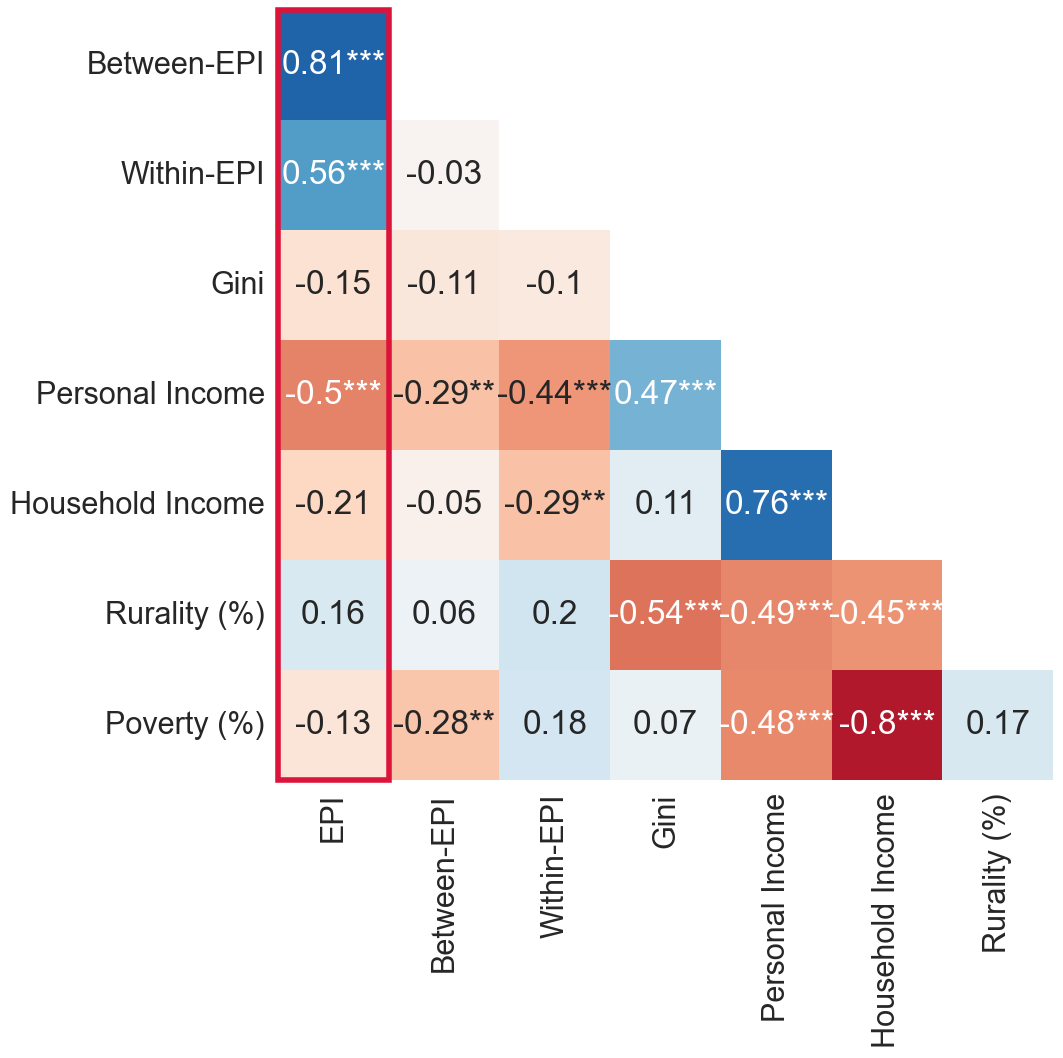

In [ ]:
def set_corr(corr, _):
    corr = round(corr, 3)
    if _ < 0.01:
        return f"{corr}***"
    elif _ < 0.05:
        return f"{corr}**"
    elif _ < 0.1:
        return f"{corr}*"
    return corr

sns.set_style("whitegrid")
sns.set(font_scale=2, style="whitegrid")
matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rcParams['axes.grid'] = True

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

dd = data3[["epi", "epi_between", "epi_within", "gini", "personal_income", "household_income", "rurality", "poverty_rate", "state"]].copy() #, "household_income"
dd = dd.rename(columns={
    "epi": "EPI",
    "epi_between": "Between-EPI",
    "epi_within": "Within-EPI",
    "poverty_rate": "Poverty (%)",
    "gini": "Gini",
    "personal_income": "Personal Income",
    "household_income": "Household Income",
    "rurality": "Rurality (%)"
})
# dd["Rurality (%)"] = dd["Rurality (%)"].astype(float)

corr_m = dd.corr()
rho = dd.corr()
pval = dd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
p = rho.round(2).astype(str) + p

p = np.tril(p.values, k=-1)

p[p==0] = np.nan
p = pd.DataFrame(p).dropna(axis=0, how="all").dropna(axis=1, how="all")
# print(p)
labels_m = list(corr_m)
corr_m = np.tril(corr_m.values, k=-1)

corr_m[corr_m==0] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

heatmap_data = pd.DataFrame(corr_m, index=labels_m, columns=labels_m).round(2)\
                .dropna(axis=0, how="all")\
                .dropna(axis=1, how="all")
#  
display()
g = sns.heatmap(heatmap_data, annot=p, vmin=-1, vmax=1, ax=ax, cmap="RdBu", fmt="", cbar=False)

g.set_ylim(heatmap_data.shape[0], 0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

from matplotlib.patches import Rectangle

wanted_label = 'Divisiveness'
wanted_index = 0 #labels.index(wanted_label)
N = len(list(heatmap_data))
x, y, w, h = 0, wanted_index, N, 1
for _ in range(1):
    g.add_patch(Rectangle((x, y), h, w, fill=False, edgecolor='crimson', lw=4, clip_on=False))

In [ ]:
dd

,EPI,Between-EPI,Within-EPI,Gini,Personal Income,Household Income,Rurality (%),Poverty (%),state
0,0.998104,0.895863,0.102241,0.611855,52327.0,70821.0,0.115668,12.8,ARIZONA
1,0.891527,0.649711,0.241816,0.619212,47154.0,50784.0,0.452568,15.2,ARKANSAS
2,0.889691,0.694546,0.195145,0.667601,70647.0,81575.0,0.063259,11.5,CALIFORNIA
3,0.971916,0.735060,0.236856,0.615041,65358.0,84954.0,0.168969,9.0,COLORADO
4,0.865559,0.788837,0.076721,0.672941,78463.0,80958.0,0.120540,9.7,CONNECTICUT
5,0.110661,0.110661,0.000000,0.648979,89735.0,90640.0,0.000000,15.0,DISTRICT OF COLUMBIA
6,0.999835,0.632466,0.367369,0.629190,51987.0,61497.0,0.261099,14.0,GEORGIA
7,0.961325,0.685064,0.276262,0.632795,62139.0,79253.0,0.121530,11.0,ILLINOIS
8,0.966905,0.725897,0.241008,0.576433,52219.0,70190.0,0.268140,11.6,INDIANA
9,0.937255,0.656615,0.280640,0.630091,50809.0,57206.0,0.269567,17.8,LOUISIANA


In [ ]:
dd.to_csv("cross_sectional/United States.csv", index=False)

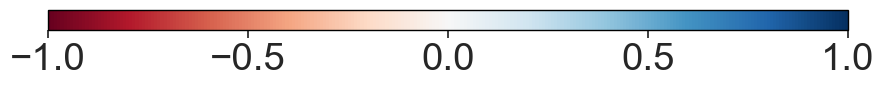

In [ ]:
import pylab as pl
import numpy as np


sns.set(font_scale=2.5, style="whitegrid")

a = np.array([[-1, 1]])
pl.figure(figsize=(10, 1))
img = pl.imshow(a, cmap="RdBu")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.2])



cb = pl.colorbar(orientation="horizontal", cax=cax)
# cb.ax.set_xticklabels(["<0.2", "0.25", "0.3", "0.35", "0.4+"])
cb.outline.set_color("#000000")
cb.outline.set_linewidth(1)

In [ ]:
def normalize(col):
    x_min = col.min()
    x_max = col.max()
    x = col
    y = (x - x_min) / (x_max - x_min)
    return y

In [ ]:
from epitools import between_p, within_p

output = []

for country, year, election in [
    ("United States", 2000, "first_round"),
    ("United States", 2004, "first_round"),
    ("United States", 2008, "first_round"),
    ("United States", 2012, "first_round"),
    ("United States", 2016, "first_round"),
    ("United States", 2020, "first_round")
]:
    df = pd.read_csv(f"data_output/{country}/{year}_{election}.csv.gz")
    ee = df.groupby("polling_id").agg({"value": "sum"})
    dd = df.groupby("candidate").agg({"value": "sum"})
    dd["rate"] = dd.apply(lambda x: x/x.sum())

    if country == "United States":
        values = list(dd[dd["rate"] > 0.1].index.unique())
    else:
        values = list(dd[dd["rate"] > RATE_THRESHOLD].index.unique())

    df = df[df["candidate"].isin(values)].copy()

    tt = df.groupby(["polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    df = tt.copy()

    N = len(df["candidate"].unique())

    df_a = between_p(df)
    df_b = within_p(df)

    df = pd.merge(df_a, df_b, on=["candidate"])

    output.append({
        "country": country,
        "year": year,
        "N": N,
        "value": np.sum((df["value_x"] + df["value_y"])),
        "between": np.sum(df["value_x"]),
        "within": np.sum(df["value_y"])
    })

df_epi_country = pd.DataFrame(output)
df_epi_country

,country,year,N,value,between,within
0,United States,2000,2,1.000354,0.790305,0.210049
1,United States,2004,2,0.998311,0.780116,0.218195
2,United States,2008,2,0.991714,0.764023,0.227691
3,United States,2012,2,0.997476,0.749278,0.248198
4,United States,2016,2,0.999022,0.704033,0.294989
5,United States,2020,2,0.994810,0.718034,0.276776


In [ ]:
df_polarization = pd.merge(df_affective, df_epi_country, how="outer", on="year")
df_polarization = pd.merge(df_polarization, df_political, how="outer", on="year")
df_polarization = df_polarization[df_polarization["year"] >= 1996]
df_polarization = df_polarization.sort_values("year")
df_polarization["affective"] = df_polarization["affective"] / 98
df_polarization["political"] = df_polarization["political"] / 11
for measure in ["affective", "value", "between", "within", "political"]:
    # df_polarization[measure] = normalize(df_polarization[measure])
    df_polarization[f"{measure}_1"] = df_polarization[measure].shift(periods=1)

df_pol_corr = df_polarization[[
    "between", "between_1", "within", "within_1", 
    "affective", "affective_1", "political", "political_1"
]].copy()
df_polarization.head()
df_polarization = df_polarization.melt(id_vars=["year"], value_vars=["affective", "political", "between", "within"])
df_polarization["variable"] = df_polarization["variable"].replace({
    "affective": "Affective",
    "political": "Political",
    # "value": "Election",
    "between": "Between",
    "within": "Within"
})

NameError: name 'df_affective' is not defined

In [ ]:
sns.set(font_scale=1.5, style="white")
fig, ax = plt.subplots(figsize=(7, 5))
g = sns.lineplot(x="year", y="value", marker="o", 
    hue="variable", lw=3, palette=["#DB2828", "#29AD02", "#240BED", "orange"], 
    data=df_polarization) 
g.set_ylabel("Polarization")
g.set_xlabel("")

plt.legend(title="", frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.075),
          fancybox=False, shadow=False, ncol=4)
sns.despine()

In [ ]:
# df_pol_corr

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5, style="whitegrid")
matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rcParams['axes.grid'] = True

items = {
    # "value": "Election ($t$)",
    # "value_1": "Election ($t - 1$)",
    "between": "Between ($t$)",
    "between_1": "Between ($t - 1$)",
    "within": "Within ($t$)",
    "within_1": "Within ($t - 1$)",
    "affective": "Affective ($t$)",
    "affective_1": "Affective ($t - 1$)",
    "political": "Political ($t$)",
    "political_1": "Political ($t - 1$)",
}
dd = df_pol_corr.copy()
# dd = dd.drop(columns=["year"])
dd = dd.rename(columns=items)

corr_m = dd.corr()
rho = dd.corr()
pval = dd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
p = rho.round(2).astype(str) + p

p = np.tril(p.values, k=-1)

p[p==0] = np.nan
p = pd.DataFrame(p).dropna(axis=0, how="all").dropna(axis=1, how="all")

labels_m = list(corr_m)
corr_m = np.tril(corr_m.values, k=-1)

corr_m[corr_m==0] = np.nan

fig, ax = plt.subplots(figsize=(9, 8))

heatmap_data = pd.DataFrame(corr_m, index=labels_m, columns=labels_m).round(2)\
                .dropna(axis=0, how="all")\
                .dropna(axis=1, how="all")

g = sns.heatmap(heatmap_data, annot=p, ax=ax, cmap="cividis", fmt="", cbar=True)

g.set_ylim(heatmap_data.shape[0], 0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)